In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# TODO: Add total spendings column

In [ ]:
# 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
# 2) MILK: annual spending (m.u.) on milk products (Continuous);
# 3) GROCERY: annual spending (m.u.) on grocery products (Continuous);
# 4) FROZEN: annual spending (m.u.) on frozen products (Continuous)
# 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
# 6) DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous);
# 7) CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
# 8) REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
# Descriptive Statistics:

# (Minimum, Maximum, Mean, Std. Deviation)
# FRESH ( 3, 112151, 12000.30, 12647.329)
# MILK (55, 73498, 5796.27, 7380.377)
# GROCERY (3, 92780, 7951.28, 9503.163)
# FROZEN (25, 60869, 3071.93, 4854.673)
# DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
# DELICATESSEN (3, 47943, 1524.87, 2820.106)

# REGION Frequency
# Lisbon 77
# Oporto 47
# Other Region 316
# Total 440

# CHANNEL Frequency
# Horeca 298
# Retail 142
# Total 440



# 1 Loading the Data, Preprocessing, Initial Data Analysis

In [4]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_og = df.copy() # keep original df for later
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


In [7]:
df = np.log(df + 1)
df_overview = df.copy() # we will use this to append the scores for an overview. Calculations are performed on df

# Data Visualisation

In [ ]:
def plot_hist_cols():
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i])


plot_hist_cols()


In [ ]:
sns.pairplot(df)


In [228]:

plot_hist_cols()


In [ ]:
sns.pairplot(df)
# TODO: Add Correlation Plot and a column with total spendings
# Barplot/Pie chart with spendings from total spendings


# 2 Detecting Anomalies

## Hard-Min Score

Compute distance to nearest neighbor for each instance. This measure is used as an outlier score. We assume that this measure is not very biased, but has a high variance. We therefore argue that using a bootstrap with the Hard-Min approach gives a more accurate and robust score. Later on, (together with some visual inspectations) we evalute the accuracy of a more robust, but more biased estimator of the scores. Note that we are interested in the resulting ranking of the scores and not the scores per se.


### Fake it till you make it: Creating an artificial "Ground Truth"

In [8]:
import math
from sklearn.utils import resample
import seaborn as sns
from scipy.stats import spearmanr

In [10]:
# Setting the HYPERPARAMETERS
N_BOOTSTRAP = 1000
SAMPLE_SIZE_FRAC  = 0.5
OUTLIERS_FRAC = 0.04 

In [11]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_og = df.copy() # keep original df for later
df = np.log(df + 1)
df_overview = df.copy() # we will use this to append the scores for an overview. Calculations are performed on df

The Spearman correlation as well as the scores increase with a higher sample size fraction (nearest neighbor distances increase monotonically since we only consider less data points). To asses the bias of the Soft-Min Estimator, which we will consider later for different values of gamma, we classify the "OUTLIERS_FRAC" % of the most likely outliers from the hard-min bootstrap and check the accuracy.

The Sample size fraction is chosen in a way s.t. the spearman correlation with the hardmin on the whole dataset is high, but not too high as well.

The the outliers frac of 4% results in 14 samples from 440 in the dataset which seemed like a reasonable guess. One can adjust this parameter when one has further domain knowledge or wants an indicator to make the outlier scores even more robust.

In [17]:
# Create Samples for Bootstrap approach
samples = [resample(df, n_samples=math.ceil(len(df) * SAMPLE_SIZE_FRAC), replace=False) for i in range(N_BOOTSTRAP)]

def hardmin_score(df):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df)
    distances, indices = nbrs.kneighbors(df)
    outlier_score_min = np.square(distances[:, 1])
    return outlier_score_min


def hardmin_bootstrap(n_bootstrap=N_BOOTSTRAP, sample_size_frac=SAMPLE_SIZE_FRAC, data=df, samples = samples):
        hard_min_scores_bootstrap = pd.DataFrame({i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))})
        #samples = [resample(df, n_samples=math.ceil(len(df) * SAMPLE_SIZE_FRAC), replace=False) for i in range(N_BOOTSTRAP)]
        for i in range(0, N_BOOTSTRAP):
                sample = samples[i]
                hard_min_scores_bootstrap.loc[i, sample.index] = hardmin_score(sample)
                
        return hard_min_scores_bootstrap

Example for the bootstrap values table below:

In [18]:
hard_min_scores_bootstrap = hardmin_bootstrap(df)
display(hard_min_scores_bootstrap)

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,NaN,0.453793,1.370179,NaN,NaN,NaN,0.517339,NaN,NaN,0.353179,...,4.321216,0.574922,0.402235,0.898605,0.556249,2.476255,2.310701,NaN,0.781245,NaN
1,1.704570,0.453793,NaN,NaN,NaN,0.984075,NaN,NaN,NaN,NaN,...,3.446799,0.574922,NaN,NaN,NaN,2.476255,NaN,NaN,NaN,NaN
2,NaN,NaN,1.302722,0.95166,NaN,0.571289,0.517339,0.432329,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.532779,NaN,5.641165
3,NaN,NaN,NaN,0.95166,NaN,0.984075,NaN,NaN,0.909097,NaN,...,NaN,NaN,NaN,1.186784,NaN,NaN,2.770299,NaN,NaN,NaN
4,1.618937,NaN,1.370179,0.95166,0.833497,NaN,0.556249,0.452970,0.941408,NaN,...,NaN,1.591158,NaN,0.898605,0.556249,2.476255,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.181445,NaN,NaN,0.95166,NaN,0.571289,NaN,0.153060,0.909097,0.721992,...,NaN,0.852232,NaN,NaN,0.926908,2.476255,3.035594,1.532779,0.781245,NaN
996,1.402676,NaN,NaN,NaN,0.833497,0.741045,0.517339,0.432329,NaN,0.790723,...,3.446799,0.574922,NaN,0.898605,NaN,2.680879,NaN,0.966305,NaN,6.237760
997,1.181445,NaN,1.370179,NaN,NaN,NaN,0.517339,NaN,NaN,0.353179,...,3.843021,0.574922,0.402235,1.379020,NaN,2.694467,NaN,NaN,NaN,NaN
998,1.618937,0.609692,1.370179,NaN,0.833497,NaN,NaN,0.609692,0.909097,0.353179,...,NaN,2.295182,3.314010,NaN,NaN,NaN,NaN,0.966305,0.781667,6.107358


We will get the hardmin-outlier score on the whole dataset as well as the described bootstrap approach without replacement. We than compare the two briefly.

In [23]:
df_overview["hardmin_score"] = hardmin_score(df)
df_overview["hardmin_bootstrap_score"] = hardmin_bootstrap(data=df).mean()
display(df_overview.head())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,hardmin_score,hardmin_bootstrap_score
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,1.181445,1.369345
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,0.257170,0.331157
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,1.302722,1.423813
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,0.951660,1.009844
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,0.833497,0.966736


In [25]:
df_overview.sort_values(by="hardmin_bootstrap_score", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,hardmin_score,hardmin_bootstrap_score
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,24.462058,30.612921
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,21.598732,23.345692
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,17.656426,21.631856
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,14.249027,17.404760
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,14.033121,17.274862
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294,9.006401,10.186361
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789,8.742070,10.099376
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,8.841779,9.731605
204,7.579168,6.793466,8.561593,7.232733,1.791759,7.192182,8.531557,8.890065
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225,6.589560,8.485375


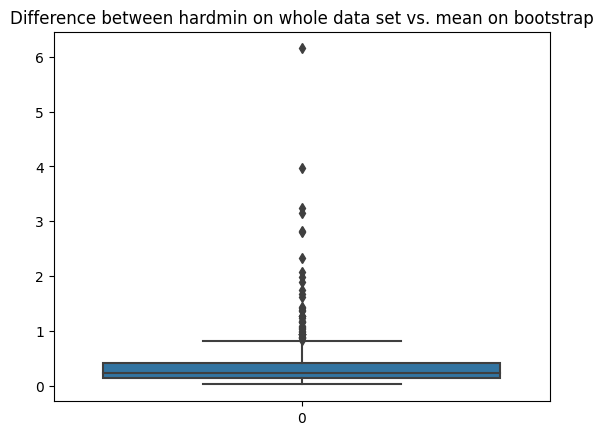

In [32]:
# Check difference! Stabilized it a little bit
sns.boxplot(np.abs(df_overview["hardmin_bootstrap_score"] - df_overview["hardmin_score"])).set_title("Difference between hardmin on whole data set vs. mean on bootstrap")
plt.show()

### Everything gets down on choosing the right evaluation metric

Compare hardmin with hardmin-bootstrap appraoch by statistics as well as artificial outlier classification.

Later when we will try to choose an educated gamma, we will use the same approach!

In [189]:
def score_bias_eval(scores, baseline=df_overview["hardmin_bootstrap_score"].to_numpy(), outlier_frac=OUTLIERS_FRAC,
                    return_p_val=False):
    n_outliers = math.ceil(len(baseline) * outlier_frac)
    spr = spearmanr(scores, baseline)
    hardmin_bootstrap_ranking = np.argsort(baseline * (-1))
    hardmin_outliers = hardmin_bootstrap_ranking[:n_outliers]
    score_outlier_ranking = np.argsort(scores * (-1))
    score_outliers = score_outlier_ranking[:n_outliers]

    accuracy = len(set(hardmin_outliers).intersection(score_outliers)) / n_outliers

    return spr[0], accuracy

spr, acc = score_bias_eval(scores=df_overview["hardmin_score"])

print(f"Bootstrap Accuracy: {acc:.2}% \nSpearman results: {spr}")

Bootstrap Accuracy: 0.86% 
Spearman results: 0.9479011758070056


## The Soft-Min Score/KDE approach

To get a better understanding what we'll do next, we will compute the soft-min scores for a fixed Gamma-Value and compare them to our baseline/ground-truth.

In [73]:
GAMMA = 1

In [86]:
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)

def softmin(z, gamma=GAMMA):
    return (-1 / gamma) * np.log( (1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z)) )


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
score_bias_eval(score="outlier_score_softmin")

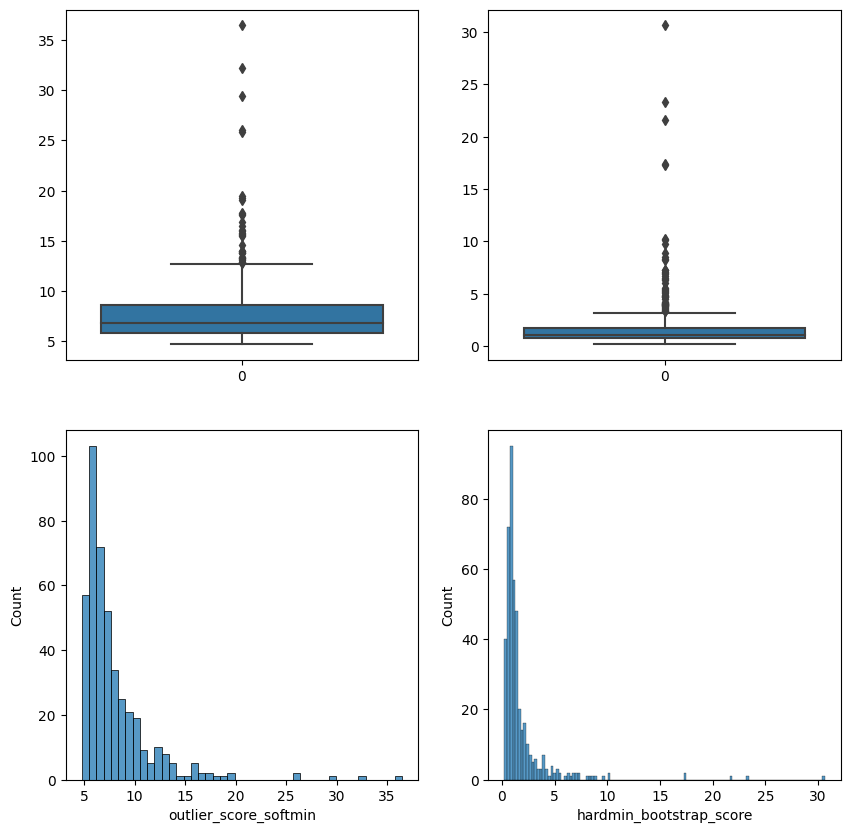

In [97]:
# Visually compare distributions of the scores
fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(df_overview["outlier_score_softmin"], ax=axs[0, 0])
sns.histplot(df_overview["outlier_score_softmin"], ax=axs[1, 0])
sns.boxplot(df_overview["hardmin_bootstrap_score"], ax=axs[0, 1])
sns.histplot(df_overview["hardmin_bootstrap_score"], ax=axs[1, 1])
plt.show()

We can see that the distributions are quite similar although they "operate" on different scales. When we thought about how to evaluate different measures, firstly we tried to use the variance of the outlier scores as a possible measure for the signal power of the respective score. But the softmin function operates on different scales for different values of gamma which makes a comparision hard. Just because a different scale/variance is used, this does not have to implicate that the score is better or worse. Instead we are interested in the resulting ranking. That's why we will focus on the spearman rank correlation as well as our "artificial" accuracy specified above in the hardmin bootstrap case.

Note that we tried different approaches, e.g. leaving the factor of 1/gamma out of the soft-min function to get comparable scales and that we will also introduce some visual inspections. For example in the following we can see how the softmin-score for a given instance changes for different values of gamma. We will use this for each instance to evaluate the development of the scores.

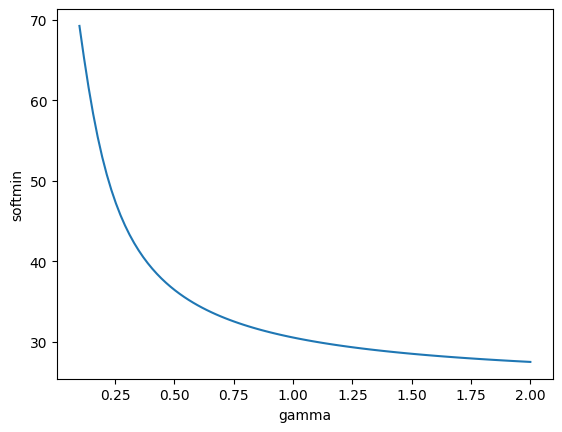

In [98]:
# 
instance = 338  # 338 has had a high outlier score
gammas = np.linspace(0.1, 2, 100)
g = sns.lineplot(
    x=gammas, y=[softmin(distances[instance, 1:], gamma) for gamma in gammas]
)
g.set_xlabel("gamma")
g.set_ylabel("softmin") 
plt.show()

We can clearly see how the scale of the softmin-score changes!

## Bootstrap/Robustness evaluation & the curse of choosing a bandwidth

Since the softminscore can be interpreted as a KDE-approach, the choosen gamma corresponds to the inverse of the bandwidth or variance of the used guassian distributions. Because of that, a high gamma leads to less biased estimates but with the cost of introducing a higher estimator variance! It is known that finding an appropiate bandwidth is crucial and a hard thing to do (and also way more important than choosing a kernel).

Consequently, if we want to choose a gamma, we have to evaluate the bias and variance of our estimator. To do this, we will use a bootstrap approach withouth resampling on a fraction size of the whole dataset. This will be set as a Hyperparameter and has to be choosen in a way, that the data is varying enough but still has enough information included/is representative for the whole dataset. To evaluate the model variance for a given gamma, we will compute the score for each instance for each bootstrap round, then compute the within-variance of each sample across the different bootstrap rounds and finally aggregate the variances for each sample with a mean across the whole dataset.

To analyse the bias, we will use the approaches discussed above.

In [100]:
def softmin(z, gamma):
    return - (1/gamma)  * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))

In [102]:
N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

scores = np.full((len(df), N_BOOTSTRAP, len(gamma_range)), np.nan) # customer x bootstrap round x gamma


for i in range(0, N_BOOTSTRAP):

    sample = samples[i]

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, indices = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])
    
    for j, gamma in enumerate(gamma_range):
        scores[sample.index, i, j] = np.apply_along_axis(softmin, 1, distances, gamma)



In [106]:
# verify normal distribution arround N_BOOTSTRAP * frac
# sns.histplot(np.sum(np.isnan(scores) == False, axis=1)[:,0]).set_xlabel("# not sampled")
# plt.show()

In [122]:
np.nanmean(scores, axis=1).shape

(440, 20)

(440, 20)

average outlier score of instance 0:


array([12.76111104, 10.45472297,  8.98427181,  7.96327225,  7.20952553,
        6.62552491,  6.15611838,  5.76830947,  5.44120295,  5.16085692,
        4.91753805,  4.70418757,  4.5155219 ,  4.34748095,  4.19687582,
        4.06115573,  3.9382489 ,  3.826451  ,  3.72434485,  3.63074134])

average outlier score of instance 338:


array([69.53614438, 54.37124559, 46.91309414, 42.86768046, 40.3717065 ,
       38.68412347, 37.46761836, 36.54911056, 35.83103811, 35.25425698,
       34.78081565, 34.38523553, 34.04977295, 33.76169075, 33.51160949,
       33.29247026, 33.09885952, 32.92655662, 32.77222269, 32.63318197])

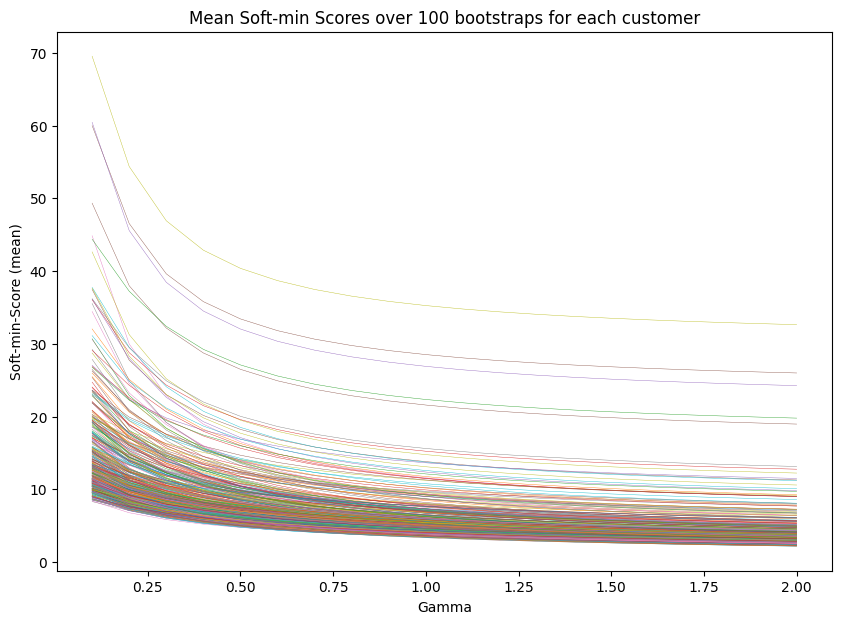

In [142]:
# average outlier score per sample, per gamma
avg_score = np.nanmean(scores, axis=1)

display(avg_score.shape)
print("average outlier score of instance 0:")
display(avg_score[0])

print("average outlier score of instance 338:")
display(avg_score[338])



fig = plt.figure(figsize=(10,7))
for i in range(len(scores)):
    plt.plot(gamma_range, avg_score[i], linewidth=0.3)
    plt.xlabel("Gamma")
    plt.ylabel("Soft-min-Score (mean)")
    plt.title(f"Mean Soft-min Scores over {N_BOOTSTRAP} bootstraps for each customer")
plt.show()

While the Soft-Min Scores are getting lower for all the samples for increasing Gammas, the ranking more or less stays the same! Especially the ones with the highest scores are still just as seperable. Hence, the variance over the scores as used before was discarded as a measure for bias.

(440, 20)

Vars of instance 0:


array([0.13025325, 0.10367846, 0.09340701, 0.08998732, 0.08979702,
       0.09086912, 0.09213065, 0.09302776, 0.09331671, 0.09294191,
       0.09195855, 0.09047974, 0.08863958, 0.08656877, 0.08438054,
       0.0821647 , 0.07998723, 0.07789303, 0.07591001, 0.07405331])

Vars of instance 338:


array([ 8.41749799, 28.97277681, 38.97054594, 43.58459073, 46.1650184 ,
       47.78476178, 48.87546317, 49.64644716, 50.21171367, 50.63831282,
       50.96794528, 51.22769646, 51.43579264, 51.60486984, 51.74391656,
       51.85947194, 51.95638845, 52.03833084, 52.10811044, 52.16791419])

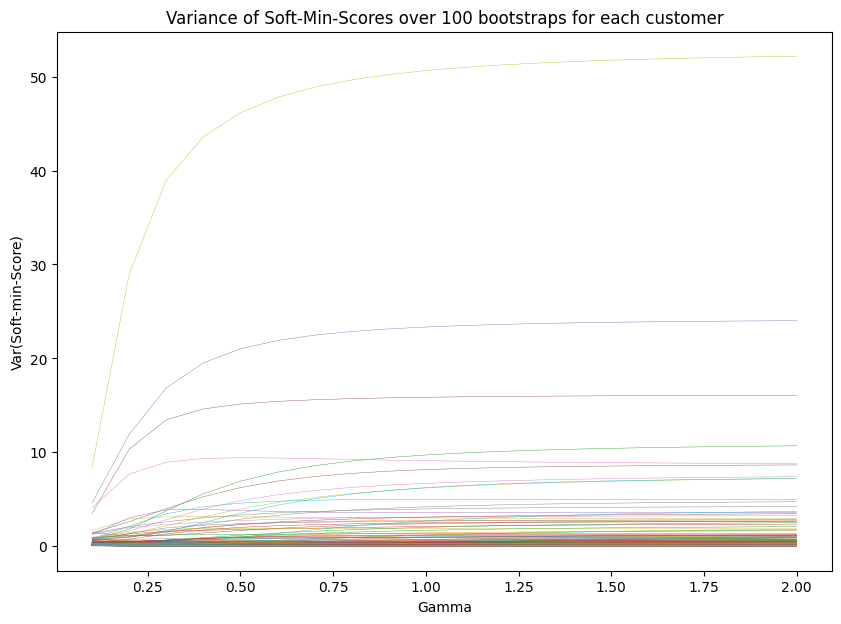

In [136]:
# calculate the spread over bootstrap dimension aka within sample variance
spread = np.nanvar(scores, axis=1)

# Comparing inlier vs outlier
display(spread.shape)
print("Vars of instance 0:")
display(spread[0])

print("Vars of instance 338:")
display(spread[338])


# all spreads per instances
fig = plt.figure(figsize=(10,7))
for i in range(len(scores)):
    plt.plot(gamma_range, spread[i], linewidth=0.3)
    plt.xlabel("Gamma")
    plt.ylabel("Var(Soft-min-Score)")
    plt.title(f"Variance of Soft-Min-Scores over {N_BOOTSTRAP} bootstraps for each customer")
plt.show()


We can see that the variance of the modul increases with increasing gamma just as expected. What strikes out is that it increases way more for outlier than for inliers. Since our purpose is to detect outliers, we have to carefully choose our gamma value to have robust estimates. 

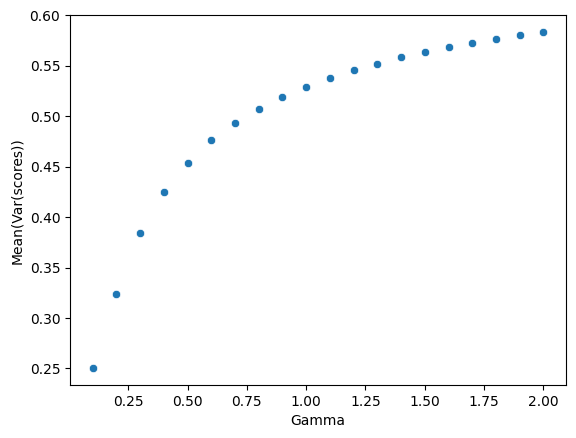

In [140]:
# Check mean behaviour as well
g = sns.scatterplot(x=gamma_range, y=np.mean(np.nanvar(scores, axis=1), axis=0))
g.set_xlabel('Gamma')
g.set_ylabel('Mean(Var(scores))')
plt.show()

Although the variance is way higher for the outliers, the mean reflects the model variance on a low scale as well.

In [190]:
print(avg_score.shape)
score_bias_eval(avg_score[:, 1])

(440, 20)


(0.7741995286414421, 0.8571428571428571)

In [208]:
def mean_var_of_most_anomalous(customer_variances, n_most_outliers_considerd = OUTLIERS_FRAC):
    n_most_outliers_considerd = math.ceil(len(customer_variances) * OUTLIERS_FRAC)
    var_of_outliers = np.sort(customer_variances)[::-1][:n_most_outliers_considerd]
    return np.mean(var_of_outliers)


In [211]:
bias_measures = np.apply_along_axis(score_bias_eval, 0, avg_score)
var_measures = np.apply_along_axis(mean_var_of_most_anomalous, 0, spread)
gamma_overview = pd.DataFrame(bias_measures, index=["Spearman Corr", "Accuracy"])
gamma_overview.loc["Model Var", :] = var_measures
gamma_overview

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Spearman Corr,0.709592,0.774200,0.818160,0.848832,0.871133,0.887817,0.900782,0.911298,0.919906,0.926971,0.933778,0.939786,0.945534,0.949966,0.954270,0.957674,0.961702,0.964929,0.967502,0.970061
Accuracy,0.857143,0.857143,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571
Model Var,2.342826,5.714836,7.742363,8.890846,9.648037,10.169274,10.532232,10.792236,10.986762,11.134332,11.249083,11.340052,11.412482,11.472102,11.524221,11.567203,11.602974,11.632989,11.658361,11.679955


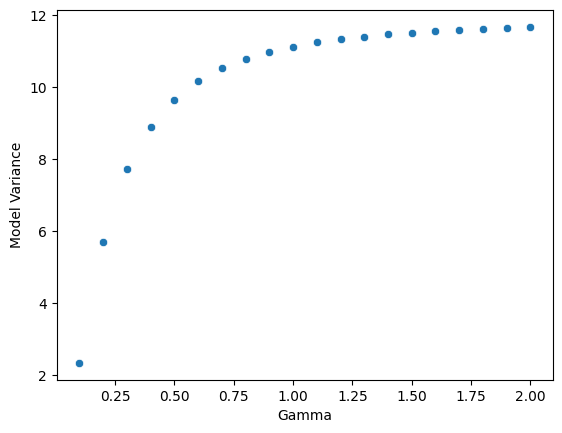

In [214]:
g = sns.scatterplot(x=gamma_range, y=var_measures)
g.set_xlabel('Gamma')
g.set_ylabel('Model Variance')
plt.show()

## Choosing the right gamma

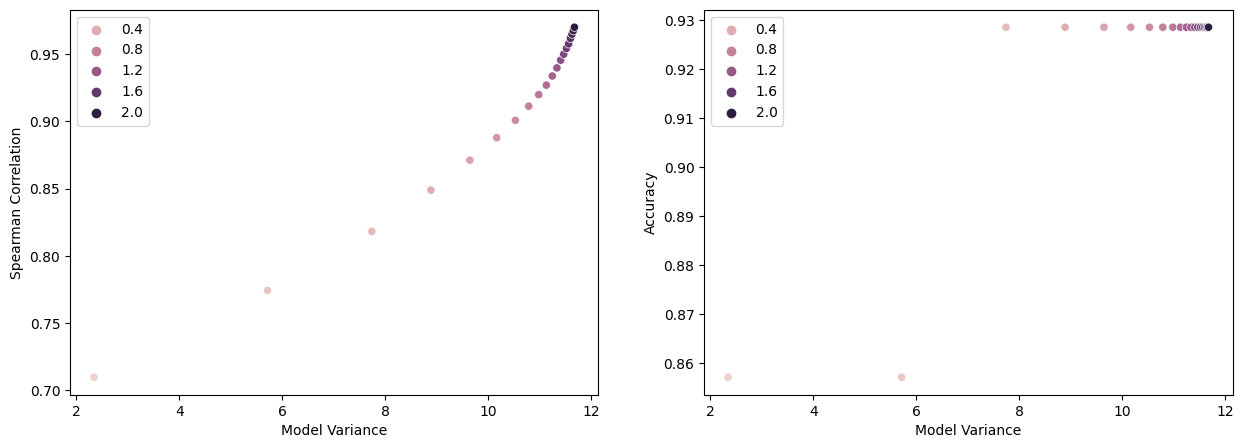

In [225]:
figure, axs = plt.subplots(1,2, figsize=(15, 5))


g = sns.scatterplot(y=gamma_overview.loc["Spearman Corr", ], x=gamma_overview.loc["Model Var", ], hue=gamma_range, ax=axs[0])
g.set_xlabel('Model Variance')
g.set_ylabel('Spearman Correlation')

g = sns.scatterplot(y=gamma_overview.loc["Accuracy", ], x=gamma_overview.loc["Model Var", ], hue=gamma_range, ax=axs[1])
g.set_xlabel('Model Variance')
g.set_ylabel('Accuracy')


plt.show()

We can clearly see that with increasing gamma, the model robustness as well its accuracy decreases. We have to choose a gamma which achieves a fair Trade-Off.

Arguabely, the gamma value should be at least above 0.3. Also a Spearman Correlation of .9 is already quite high while the curve is getting very step after a Spearman value of y. The corresponding gamma value should therefore not exceed 1.2. For the further analysis we take the last value which is still on the line which could be approcimited by a line. 

This is leeds to a Gamma value of 1.


One could also restrict the spearman correlation on the most probable outliers just like in the case of the model variance. But since we also use the "artificial" Accuracy, we can see that the Score is apropiate even in the "crucial" area of interest.

# 3 Explaining Anomalies

In [ ]:
def relevance(x, yj, gamma):
    """Calculate layer-wise relevance propagation
    @x: array of instances
    @yj: softmin scores of all j instances
    @gamma: gamma used for softmin 
    """

    Rji = np.zeros(x.shape)

    # calculation per instance
    for j in range(len(x)):

        # mask is used to exclude the current instance j
        mask = np.full((len(x)), True)
        mask[j] = False

        # save xk - xj
        xk_j = x - x[j]

        # calculate zk = ||xj - xk||^2
        zk = np.square(np.linalg.norm(xk_j, axis=1))

        # 1. First, one identifies to what extent each data point has contributed to the anomaly score of instance j
        temp = np.exp(-gamma * zk[mask])
        Rk = temp / np.sum(temp) * yj[j]

        # 2. Then, these scores can be propagated back to the input features by observing that the (squared)
        # Euclidean distance entering the anomaly score can be decomposed in terms of individual components:
        Rji[j, :] = np.sum(np.square(xk_j)[mask] / zk[mask][:, None] * Rk[:, None], axis=0)

    return Rji


In [ ]:
gamma = 1

# Calculate anomaly scores
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, _ = nbrs.kneighbors(df)
yj = np.apply_along_axis(softmin_og, 1, np.square(distances[:, 1:]), gamma)

x = df.to_numpy()
Rji = relevance(x, yj, gamma)

# confirm conservation property
np.all(np.sum(Rji, axis=1) - yj <= 1e-14)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

f, ax = plt.subplots(figsize=(10,8))
points = ax.scatter(x=X_embedded[:,1], y=X_embedded[:,0], c=yj, s=30, cmap=plt.cm.get_cmap('viridis_r'))
f.colorbar(points)
ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")
ax.set_title("Outlier score in 2D projection (t-SNE) ")
plt.show()


In [ ]:
instance = 338
g = sns.barplot(x=Rji[instance], y=list(map(str, list(zip(df_og.iloc[instance].index, df_og.iloc[instance].values)))))
g.set_xlim(0,np.max(Rji))
plt.show()

# TODO WHY IS Fresh = 3 not relevant for outlier score?
print("Ri:", Rji[instance])
print("Outlier score:", yj[instance])
display(df.iloc[instance])
display(df.describe())

## Experiment to use explanations of these outlier scores for the reproducibility experiment in task 2

In [ ]:
# 50% random sample without replacement
# for each gamma:
#   calculate anomaly scores for sample instances
#   calculate relevance 
#   save relevance (per component) for later analysis

gamma = 1

N_BOOTSTRAP = 100

Rji_BS = np.full((440, N_BOOTSTRAP, len(gamma_range), 6), np.nan)

for i in range(N_BOOTSTRAP):

    sample = df.sample(frac=0.5)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, _ = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])

    for k, g in enumerate(gamma_range):
        yj = np.apply_along_axis(softmin_og, 1, distances, g)
        Rji_BS[sample.index, i, k, :] = relevance(sample.to_numpy(), yj, g)


In [ ]:
# for each instance, for each sample, for each gamma, the relevance per component
Rji_BS.shape

### Experiment for all components at once

In [ ]:
# analyse the mean Euclidean distance between the relevance components over all bootstrap samples (per gamma and per instance)
# since the range of the anomaly scores differes with gamma, the range of the relevance components will also depend on gamma

from scipy.spatial import distance

mean_dist = np.zeros((len(Rji_BS), len(gamma_range)))
var_dist = np.zeros((len(Rji_BS), len(gamma_range)))

# iterate over instances
for j in range(len(Rji_BS)):
    # iterate over gammas
    for k in range(len(gamma_range)):
        mean_dist[j,k] = np.nanmean(distance.pdist(Rji_BS[j,:,k,:]))
        var_dist[j,k] = np.nanvar(distance.pdist(Rji_BS[j,:,k,:]))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()


for i in range(len(var_dist)):
    axs[0].plot(gamma_range, var_dist[i], linewidth=0.3)

sns.scatterplot(x=gamma_range, y=np.mean(var_dist, axis=0), ax=axs[2])



for i in range(len(mean_dist)):
    axs[1].plot(gamma_range, mean_dist[i], linewidth=0.3)

sns.scatterplot(x=gamma_range, y=np.var(mean_dist, axis=0), ax=axs[3])


axs[0].set_ylabel("instance variance of component distance")
axs[1].set_ylabel("instance mean of component distance")
axs[2].set_ylabel("mean of instance variance of component distance")
axs[3].set_ylabel("variance of instance mean of component distance")
for ax in axs:
    ax.set_xlabel("gamma")

plt.show()


### Experiment PER COMPONENT

In [ ]:
component = 0

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()


spread = np.nanvar(Rji_BS[:, :, :, component], axis=1)

for i in range(len(scores)):
    axs[0].plot(gamma_range, spread[i], linewidth=0.3)

sns.scatterplot(x=gamma_range, y=np.mean(spread, axis=0), ax=axs[2])




avg_rel = np.nanmean(Rji_BS[:, :, :, component], axis=1)

for i in range(len(scores)):
    axs[1].plot(gamma_range, avg_rel[i], linewidth=0.3)

sns.scatterplot(x=gamma_range, y=np.var(avg_rel, axis=0), ax=axs[3])


axs[0].set_ylabel("instance variance of relevance")
axs[1].set_ylabel("instance mean of relevance")
axs[2].set_ylabel("mean of instance variance of relevance")
axs[3].set_ylabel("variance of instance mean of relevance")
for ax in axs:
    ax.set_xlabel("gamma")

plt.show()


In [ ]:
# TODO do these findings match with our other findings?
# TODO the components behave differently - why?

# 4 Cluster Analysis